Copied with some personal notes from: http://jlomnitz.github.io/design-space-toolbox/elucidating_genotype_phenotype.html

In [1]:
import dspace
import dspace.plotutils

import matplotlib
import scipy
import math
from scipy.integrate import odeint
%matplotlib inline

# We create an alias for the matplotlib.pyplot module
import matplotlib.pyplot as pyplot

# We create an alias for the numpy and pandas
import numpy as np
import pandas as pd

import dspace.display

import IPython
import ipywidgets

print 'dspace            ' + dspace.__version__
print 'IPython           ' + IPython.__version__
print 'IPywidgets        ' + ipywidgets.__version__
print 'libdesignspace    ' + dspace.__c_toolbox__.__version__
print 'matplotlib        ' + matplotlib.__version__
print 'numpy             ' + np.__version__
print 'sciPy             ' + scipy.__version__

dspace            0.3.0a4
IPython           5.5.0
IPywidgets        6.0.0
libdesignspace    0.3.0a6
matplotlib        2.2.2
numpy             1.14.1
sciPy             1.1.0


## Scipy implementation of the equations

In [2]:
def int_model(par,initial_cond,start_t,end_t,incr):
    '''par and initial_cond are dictionaries'''
    
    def model(y,t):
        X1,X2,X3,X4 = y
    
        X1p = a1 * ( (rho1**-1 + (X2/K2A)**2 + rho1**-1*(X4/K4)**2) / (1 + (X2/K2A)**2 + (X4/K4)**2) ) - b1*X1
        X2p = a2*X1 - b2*X2
        X3p = a3*( (rho3**-1 + (X2/K2R)**2) / (1 + (X2/K2R)**2) ) - b3*X3
        X4p = a4*X3-b4*X4

        return [X1p,X2p,X3p,X4p]
    
    #-time-grid-----------------------------------
    t  = np.linspace(start_t, end_t,incr)
#     a1,a2,a3,a4,b1,b2,b3,b4,rho,rho3,K2,K4a,K2r = par
    parlist = ['a1','a2','a3','a4','b1','b2','b3','b4','rho1','rho3','K2A','K2R','K4']
    a1,a2,a3,a4,b1,b2,b3,b4,rho1,rho3,K2A,K2R,K4 = [par[k] for k in parlist]

    variables = ['X1','X2','X3','X4']
    initial_cond = [initial_cond[k] for k in variables]
    
    ds = odeint(model,initial_cond,t)

    x = {variables[i]:ds[:,i] for i in range(len(ds[0,:]))}
    
    return (x,t)

Lomnitz 2015 equations
![](Lomnitz2015_notebook_images/equations_nps_lomnitz2015.png)

The system recast in GMA form
![](Lomnitz2015_notebook_images/GMA_equations_npj_lomnitz2015.png)

In [3]:
equation_strings = ['X1. = a1*rho1^-1*X5^-1 \
                           + a1*X2^2*K2A^-2*X5^-1 \
                           + a1*rho1^-1*X4^2*K4^-2*X5^-1 - b1*X1',
                    'X2. = a2*X1 - b2*X2',
                    'X3. = a3*rho3^-1*X6^-1 + a3*X2^2*K2R^-2*X6^-1 - b3*X3',
                    'X4. = a4*X3 - b4*X4',
                    'X5 = 1 + X2^2*K2A^-2 + X4^2*K4^-2',
                    'X6 = 1 + X2^2*K2R^-2'
                    ]

# Again we define the simplified to latex dictionary for the model 
symbols = {'X1':'X_1',
           'X2':'X_2',
           'X3':'X_3',
           'X4':'X_4',
           'X5':'X_5',
           'X6':'X_6',
           'a1':r'\alpha_1',
           'a2':r'\alpha_2',
           'a3':r'\alpha_3',
           'a4':r'\alpha_4',
           'b1':r'\beta_1',
           'b2':r'\beta_2',
           'b3':r'\beta_3',
           'b4':r'\beta_4',
           'rho1':r'\rho_1',
           'rho3':r'\rho_3',
           'K2R':'K_{2R}',
           'K2A':'K_{2A}',
           'K4':'K_4'}

equations_object = dspace.Equations(equation_strings, latex_symbols=symbols)
ds = dspace.DesignSpace(equations_object, constraints=['rho1 > 1', 'rho3 > 1'])
ds.equations

X1.=a1*rho1^-1*X5^-1+a1*K2A^-2*X2^2*X5^-1+a1*rho1^-1*K4^-2*X4^2*X5^-1-b1*X1
X2.=a2*X1-b2*X2
X3.=a3*rho3^-1*X6^-1+a3*K2R^-2*X2^2*X6^-1-b3*X3
X4.=a4*X3-b4*X4
X5=1+K2A^-2*X2^2+K4^-2*X4^2
X6=1+K2R^-2*X2^2

we automatically enumerate the model phenotypes and identify the phenotypic repertoire of the system,


In [4]:
phenotypic_repertoire = ds.valid_cases()
len(phenotypic_repertoire)

15

with the phenotypic repertoire identified, we automatically determine a set of parameter values and determine if the phenotype is stable, unstable, or has the potential to oscillate. We achieved this using a simple strategy: we (1) automatically determine a set of parameter values within the interior of this phenotype and (2) calculate the number of eigenvalues with a positive real part using the Routh criteria (14). Using these two steps, we reproduce the data shown in Table 1 of the Main Text,

In [5]:
print 'Automatically generated reproduction of Table S1.\n'

# We define the table column headers in a list.
headers = ['Case #', 'Signature', '# of pos. real eigen.']
widths = [6, 12, 23]
print ' '+'  '.join([headers[i].center(widths[i]) for i in range(len(headers))])
for case_number in phenotypic_repertoire:
    case = ds(case_number)
    p = case.valid_parameter_set()
#     p = case.valid_interior_parameter_set()
    
    # We calculate the number of eigenvalues with positive real parts.
    positive_real_eigenvalues = case.positive_roots(p)
    row = [str(case_number), 
           case.signature, 
           str(positive_real_eigenvalues)]
    print ' '+'  '.join([row[i].center(widths[i]) for i in range(len(row))]) 

Automatically generated reproduction of Table S1.

 Case #   Signature     # of pos. real eigen. 
   1     111111111111             0           
   7     111121111111             0           
   8     111121111121             0           
   13    211111111111             1           
   15    211111112111             0           
   17    211111113111             1           
   19    211121111111             1           
   20    211121111121             1           
   21    211121112111             0           
   22    211121112121             0           
   23    211121113111             2           
   24    211121113121             1           
   29    311111113111             0           
   35    311121113111             0           
   36    311121113121             0           


From the table above we have found one phenotype that has the potential to oscillate (two eigenvalues with positive real part).

In the following block we explore the phenotype with oscillatory potential, Case 23, and its context by looking at the neighboring phenotypes. We create the Case object corresponding to Case 23 and automatically determine a set of parameter values that is 3 decades away from the nearest boundaries.

In [6]:
case23 = ds(23)
pvals = case23.valid_interior_parameter_set(distance=1e3)
for parameter_name in pvals:
    print parameter_name + ' = ' + str(pvals[parameter_name])

b4 = 1.0
rho3 = 100.0
rho1 = 100.0
b3 = 1.0
a1 = 3.16227766017
K2R = 1.0
a3 = 1.0
a2 = 1.0
b1 = 1.0
b2 = 1.0
K4 = 0.0316227766017
K2A = 0.316227766017
a4 = 1.0


We visualize this phenotype and its context with a 2-D design space plot. We specify the slice parameters,  β2β2  and  β4β4 , and a range for each to plot, in this example 2 decades centered on the automatcally determined parameter values for Case 23 (●).

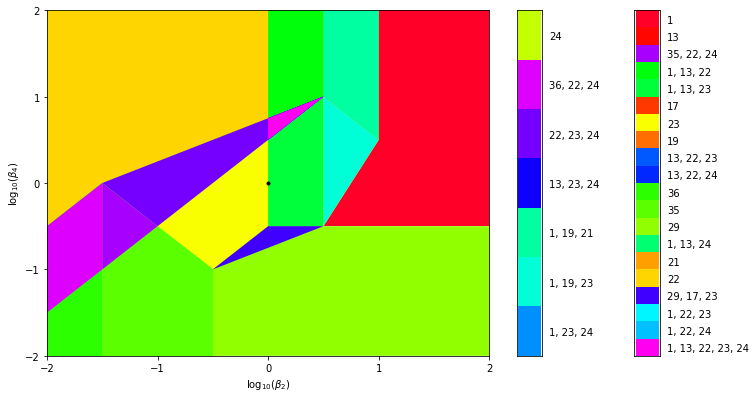

In [7]:
x_parameter = 'b2'
y_parameter = 'b4'

range_x = [pvals[x_parameter]*1e-2, pvals[x_parameter]*1e2]
range_y = [pvals[y_parameter]*1e-2, pvals[y_parameter]*1e2]

fig = pyplot.figure()
fig.set_size_inches(12, 6)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
cdict=ds.draw_2D_slice(ax, pvals, 
                       x_parameter, y_parameter,
                       range_x, range_y, intersections=[1, 3, 5])
axticks=ax.set_xticks([-2, -1, 0, 1, 2])
axticks=ax.set_yticks([-2, -1, 0, 1, 2])

_=ax.plot(np.log10(pvals[x_parameter]), np.log10(pvals[y_parameter]), 'k.')

We can determine the stability of the fixed points within this slice, as determined by the number of eigen-values with a positive-real part, and represent this visually in the following plot,

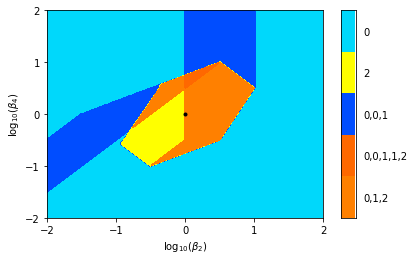

In [8]:
# We define a color dictionary for the stability plots. 
stability_colors = {'0':(0.0, 0.8471, 0.9843, 1.0),
                    '2':(1., 1., 0., 1.),
                    '1':(1., 0., 0., 1.),
                    '0,1':(1., 0., 0., 1.),
                    '0,1,2':(1., 0.5, 0., 1.)}

fig = pyplot.figure()
fig.set_size_inches(6, 3.6)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
cdict=ds.draw_2D_positive_roots(ax, pvals,
                                x_parameter, y_parameter,
                                range_x, range_y,
                                color_dict=stability_colors,
                                resolution=300)
_=ax.plot(np.log10(pvals[x_parameter]), np.log10(pvals[y_parameter]), 'k.')
_=ax.set_xticks([-2, -1, 0, 1, 2])
_=ax.set_yticks([-2, -1, 0, 1, 2])

This plot shows regions of monostability (blue), oscillatory potential (yellow), multistability (red) and overlaps between stable, exponentially unstable and oscillatory unstable phenotypes (orange). The orange regions have the potential to generate global bifurcations known as Saddle Node into Limit Cycle bifurcations (SNIC) that result in a transition from a stable steady state to full-blown oscillations (10).
The potential for oscillation can be tested by simulating the original equations. Here, we simulate the dynamics of the full system using a thin python interface for the Sundials CVODE solver (15). We import the python interface to the CVODE solver into the python environment. This interface only accepts systems of differential equations; in order to simulate the system we define the original equations using a string representation.

We choose the steady-state values at the automatically determined parameter values obtained from the design space approximation as the initial conditions for the simulation.

In [9]:
initial_conditions = case23.steady_state(pvals)
# We remove the values for the auxiliary variables (not defined for the original systems).
_=initial_conditions.pop('X5')
_=initial_conditions.pop('X6')

These are approximate values but they should be near the actual steady-state solution and the instability will repel the system from the actual steady-state solution towards a stable limit cycle, as shown below,

1.0


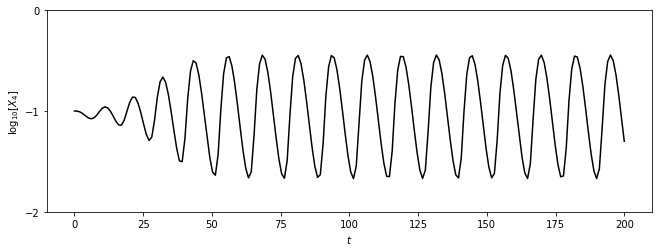

In [10]:
print pvals['b2']

# t, x = integrate.(equation_dictionary, initial_conditions, pvals, 0, 200, 0)
x, t = int_model(pvals,initial_conditions,0,200,200)

fig = pyplot.figure()
fig.set_size_inches(12., 4)
ax = fig.add_axes([0.1, 0.1, 0.7, 0.7])
ax.plot(t, np.log10(x['X4']), 'k')
ax.set_ylim(-2, 0)
_=ax.set_yticks([-2, -1, 0])
_=ax.set_xlabel('$t$')
_=ax.set_ylabel('$\log_{10}[X_4]$')

The simulation shows that the potential for oscillation results in true oscillations. The oscillations are centered around the value of the initial conditions that should be near the steady-state solution of the system. If we keep the  β4 parameter fixed at  β4=1, and allow  β2 to vary, we see a series of dynamic behaviors. According to the design space approximation, as we increase  β2 from  β2=1×10−2, the system goes from being stable, then bistable (hysteretic), then oscillatory, then overlap between unstable, stable and oscillatory, followed by stable. The induction curve for the original system can be shown using a simulations using a strategy involving numerical continuation.

We simulate the system at  β2=β2,0β2=β2,0  until it reaches an attractor (steady state or limit cycle) and record the min and max values. The final values of the simulation are stored as the initial conditions for the next simulation with a small increase in the value of the  β2β2  parameter, given by  Δβ2Δβ2 , and again we record the min and max values of the attractor. This is repeated iteratively such that the value for  β2β2  at the  ii -th iteration is  β2,i=β2,i−1+Δβ2β2,i=β2,i−1+Δβ2 , where  i=1,2,3,...,ni=1,2,3,...,n . We repeat this process starting with  β2=β2,nβ2=β2,n  and reverse the direction so  β2,i=β2,i+1−Δβ2β2,i=β2,i+1−Δβ2  until  β2=β2,0β2=β2,0 .

In [11]:
pvals['b2'] = 1e-2
pvals['b4'] = 1
case = ds(ds.valid_cases(p_bounds=pvals)[0])


initial_conditions = case.steady_state(pvals)
# We remove the values for the auxiliary variables (not defined for the original systems).
_=initial_conditions.pop('X5')
_=initial_conditions.pop('X6')

x_vals1 = np.logspace(-2, 1, 200)
y_vals1 = dict(min_val = [], max_val = [])
x_vals2 = np.logspace(1, -2, 200)
y_vals2 = dict(min_val = [], max_val = [])

variables = ['X1','X2','X3','X4']
for x in x_vals1:
    pvals['b2'] = x
#     t, y = integrate(equation_dictionary, initial_conditions, pvals, 0, 2000, 0)
    y, t = int_model(pvals,initial_conditions,0,2000,300)
    initial_conditions = {i:y[i][-1] for i in y}
#     t, y = integrate(equation_dictionary, initial_conditions, pvals, 0, 1000, 0)
    y, t = int_model(pvals,initial_conditions,0,1000,300)
    y = y['X2']
    y_vals1['min_val'].append(np.min(y))
    y_vals1['max_val'].append(np.max(y))

for x in x_vals2:
    pvals['b2'] = x
#     t, y = integrate(equation_dictionary, initial_conditions, pvals, 0, 2000, 0)
    y, t = int_model(pvals,initial_conditions,0,2000,300)
    initial_conditions = {i:y[i][-1] for i in y}
#     t, y = integrate(equation_dictionary, initial_conditions, pvals, 0, 1000, 0)
    y, t = int_model(pvals,initial_conditions,0,1000,300)
    y = y['X2']
    y_vals2['min_val'].append(np.min(y))
    y_vals2['max_val'].append(np.max(y))

The results of the forward and reverse continuations are shown below. The forward continuation is shown in red, the backward continuation is shown in blue. An overlap of the forward and reverse continuations is shown in purple. The approximated bifurcation using the design space method is represented by the gray line: a solid line represents a stable steady state, dashed line represents an oscillatory steady state and the dotted line represents an unstable steady state.


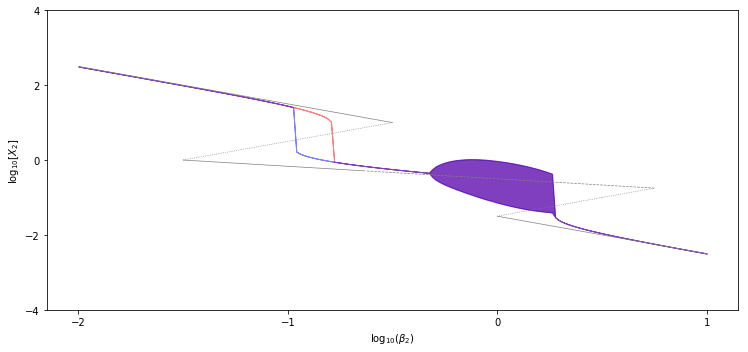

In [12]:
fig = pyplot.figure()
fig.set_size_inches(12., 5.2)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Design space eigenvalues: 0,1 or 2 with different line types
ds.draw_1D_positive_roots(ax, 'log(X2)', pvals,
                          'b2',
                          [1e-2, 1e1],
                          resolution=200,
                          line_dict={2:{'ls':'--', 'c':'gray', 'lw':0.7}, 
                                     1:{'ls':':', 'c':'gray', 'lw':0.7}, 
                                     0:{'ls':'-', 'c':'gray', 'lw':0.7}}
                          )

#  full model simulations
ax.fill_between(np.log10(x_vals1), np.log10(y_vals1['min_val']), y2=np.log10(y_vals1['max_val']), color='r', alpha=0.5)
ax.fill_between(np.log10(x_vals2), np.log10(y_vals2['min_val']), y2=np.log10(y_vals2['max_val']), color='b', alpha=0.5)
ax.set_xlabel(r'$\log_{10}(\beta_2)$')
ax.set_ylabel(r'$\log_{10}[X_2]$')
ax.set_ylim([-4, 4])
ax.set_yticks([-4, -2, 0, 2, 4])
_=ax.set_xticks([-2, -1, 0, 1])

The numerical continuation shows regions of bistability (forward and reverse continuations do not overlap) that result in a hysteretic loop. In addition, we see a region of oscillation given by the envelope of the oscillation (shown by the purple area where the min and max do not overlap) that begins with small amplitudes (super-critical hopf bifurcation) and abruptly collapses to a stable node (SNIC bifurcation). In addition, the design space approximation correctly predicts the existance of stable, unstable and oscillatory phenotypes but over-estimates the regions of hysteresis and oscillation (3).

**Check** decrease b2 to get lower amplitude waves but stay within the oscillation area

0.5


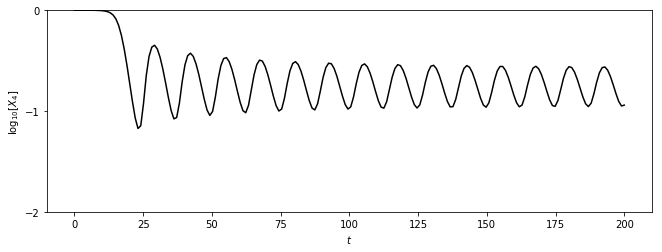

In [13]:
pvals['b2'] = 0.5
print pvals['b2']

# t, x = integrate.(equation_dictionary, initial_conditions, pvals, 0, 200, 0)
x, t = int_model(pvals,initial_conditions,0,200,200)

fig = pyplot.figure()
fig.set_size_inches(12., 4)
ax = fig.add_axes([0.1, 0.1, 0.7, 0.7])
ax.plot(t, np.log10(x['X4']), 'k')
ax.set_ylim(-2, 0)
_=ax.set_yticks([-2, -1, 0])
_=ax.set_xlabel('$t$')
_=ax.set_ylabel('$\log_{10}[X_4]$')